<a href="https://colab.research.google.com/github/camulro/Aprendizaje-I-new/blob/main/3_biclustering_20newsgroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="mbit-logo.png" align="right" style="float" width="200">
<font color="#CA3532"><h1 align="left">Biclustering</h1></font>
<font color="#6E6E6E"><h2 align="left">Text documents dataset</h2></font>

In [1]:
# From:

# http://www.stats.ox.ac.uk/~sejdinov/teaching/dmml/bicluster.html

The dataset comprises around 10000 newsgroups posts on 20 topics such that the resulting document-word biclusters indicate subsets of words which are used more often in certain subsets of documents.

In [2]:
from collections import defaultdict
import operator
import re
from time import time

import numpy as np
from sklearn.cluster import SpectralCoclustering
from six import iteritems
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.cluster import v_measure_score
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
def number_aware_tokenizer(doc):
    """ Tokenizer that maps all numeric tokens to a placeholder.

    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    token_pattern = re.compile(u'(?u)\\b\\w\\w+\\b')
    tokens = token_pattern.findall(doc)
    tokens = ["#NUMBER" if token[0] in "0123456789_" else token
              for token in tokens]
    return tokens

# exclude 'comp.os.ms-windows.misc'
categories = ['alt.atheism', 'comp.graphics',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'comp.windows.x', 'misc.forsale', 'rec.autos',
              'rec.motorcycles', 'rec.sport.baseball',
              'rec.sport.hockey', 'sci.crypt', 'sci.electronics',
              'sci.med', 'sci.space', 'soc.religion.christian',
              'talk.politics.guns', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']
newsgroups = fetch_20newsgroups(categories=categories)
y_true = newsgroups.target

In [4]:
print(newsgroups.data[0])

From: cst@blueoak.berkeley.edu (Courtney Terry)
Subject: For Sale: 1969 karmann ghia
Organization: University of California, Berkeley
Lines: 25
Distribution: ba
NNTP-Posting-Host: blueoak.berkeley.edu

*******************************************************
                   1969 karmann ghia
*******************************************************

This car is in excellent running condition:
               *********
  *49,000 mi on new engine
  *new tires (Aug 92)
  *new clutch (91)
  *new carb (91)
  *original radio (am/fm)
  *upholstery in great shape
  *burgundy exterior/ black interior

This car has been well-maintained with regular tune-ups.
Unfortunately, the car's previous owner had a minor
front-end collision.  The right front nose is dented
and patched up with bondo.  I have the hard-to-find part
needed to repair this damage.  Besides that damage, the car
is in excellent condition. $1600/bo

Courtney  email: cst@blueoak.berkeley.edu
          phone (after 5 on weekdays): 510-

Documents will be represented using tf-idf (term frequency–inverse document frequency) vectorization. The result is a 10723x22217 sparse matrix (number of documents by number of words in the dictionary).

In [5]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=5,
                             tokenizer=number_aware_tokenizer)

cocluster = SpectralCoclustering(n_clusters=len(categories),
                                 svd_method='arpack', random_state=0)
X = vectorizer.fit_transform(newsgroups.data)

feature_names = vectorizer.get_feature_names()
document_labels = list(newsgroups.target_names[i] for i in newsgroups.target)

print("number of documents:", X.shape[0])
print("number of words    :", X.shape[1])

number of documents: 10723
number of words    : 22217


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X[0]

<1x22217 sparse matrix of type '<class 'numpy.float64'>'
	with 55 stored elements in Compressed Sparse Row format>

In [ ]:
feature_names[:10]

['#NUMBER',
 'a1',
 'a137490',
 'a2',
 'a2i',
 'a5',
 'a_rubin',
 'aa',
 'aa05233',
 'aa229']

In [ ]:
print(newsgroups.data[0])
print(np.array(feature_names)[np.where(X[0].todense())[1]])

From: cst@blueoak.berkeley.edu (Courtney Terry)
Subject: For Sale: 1969 karmann ghia
Organization: University of California, Berkeley
Lines: 25
Distribution: ba
NNTP-Posting-Host: blueoak.berkeley.edu

*******************************************************
                   1969 karmann ghia
*******************************************************

This car is in excellent running condition:
               *********
  *49,000 mi on new engine
  *new tires (Aug 92)
  *new clutch (91)
  *new carb (91)
  *original radio (am/fm)
  *upholstery in great shape
  *burgundy exterior/ black interior

This car has been well-maintained with regular tune-ups.
Unfortunately, the car's previous owner had a minor
front-end collision.  The right front nose is dented
and patched up with bondo.  I have the hard-to-find part
needed to repair this damage.  Besides that damage, the car
is in excellent condition. $1600/bo

Courtney  email: cst@blueoak.berkeley.edu
          phone (after 5 on weekdays): 510-

In [ ]:
print("Coclustering...")
start_time = time()
cocluster.fit(X)
y_cocluster = cocluster.row_labels_

Coclustering...


In [ ]:
cocluster.n_clusters

19

In [ ]:
cocluster.row_labels_.shape

(10723,)

In [ ]:
def bicluster_ncut(i):
    rows, cols = cocluster.get_indices(i)
    if not (np.any(rows) and np.any(cols)):
        import sys
        return sys.float_info.max
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]
    # Note: the following is identical to X[rows[:, np.newaxis], cols].sum() but
    # much faster in scipy <= 0.16
    weight = X[rows][:, cols].sum()
    cut = (X[row_complement][:, cols].sum() +
           X[rows][:, col_complement].sum())
    return cut / weight


def most_common(d):
    """Items of a defaultdict(int) with the highest values.

    Like Counter.most_common in Python >=2.7.
    """
    return sorted(iteritems(d), key=operator.itemgetter(1), reverse=True)


bicluster_ncuts = list(bicluster_ncut(i)
                       for i in range(len(newsgroups.target_names)))
best_idx = np.argsort(bicluster_ncuts)[:5]

print()
print("Best biclusters:")
print("----------------")
for idx, cluster in enumerate(best_idx):
    n_rows, n_cols = cocluster.get_shape(cluster)
    cluster_docs, cluster_words = cocluster.get_indices(cluster)
    if not len(cluster_docs) or not len(cluster_words):
        continue

    # categories
    counter = defaultdict(int)
    for i in cluster_docs:
        counter[document_labels[i]] += 1
    cat_string = ", ".join("{:.0f}% {}".format(float(c) / n_rows * 100, name)
                           for name, c in most_common(counter)[:3])

    # words
    out_of_cluster_docs = cocluster.row_labels_ != cluster
    out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
    word_col = X[:, cluster_words]
    word_scores = np.array(word_col[cluster_docs, :].sum(axis=0) -
                           word_col[out_of_cluster_docs, :].sum(axis=0))
    word_scores = word_scores.ravel()
    important_words = list(feature_names[cluster_words[i]]
                           for i in word_scores.argsort()[:-11:-1])

    print("bicluster {} : {} documents, {} words".format(idx, n_rows, n_cols))
    print("categories   : {}".format(cat_string))
    print("words        : {}\n".format(', '.join(important_words)))


Best biclusters:
----------------
bicluster 0 : 1946 documents, 4366 words
categories   : 23% talk.politics.guns, 19% talk.politics.misc, 14% sci.med
words        : gun, guns, geb, banks, firearms, drugs, gordon, clinton, cdt, amendment

bicluster 1 : 1159 documents, 3289 words
categories   : 29% talk.politics.mideast, 26% soc.religion.christian, 25% alt.atheism
words        : god, jesus, christians, atheists, kent, sin, morality, belief, resurrection, marriage

bicluster 2 : 2244 documents, 2859 words
categories   : 18% comp.sys.mac.hardware, 16% comp.sys.ibm.pc.hardware, 16% comp.graphics
words        : voltage, receiver, circuit, shipping, compression, stereo, processing, hardware, package, timing

bicluster 3 : 1812 documents, 2701 words
categories   : 26% rec.motorcycles, 23% rec.autos, 13% misc.forsale
words        : bike, car, dod, ride, motorcycle, engine, cars, bikes, honda, helmet

bicluster 4 : 12 documents, 152 words
categories   : 100% rec.sport.hockey
words        : scor

In [ ]:
cmap = plt.cm.bwr

sorted_rows_inds = np.argsort(cocluster.row_labels_)
sorted_cols_inds = np.argsort(cocluster.column_labels_)

fit_data = X[sorted_rows_inds]
fit_data = fit_data[:, sorted_cols_inds]

In [ ]:
vmax = max([abs(X.min()), abs(X.max())])
vmax = 0.001

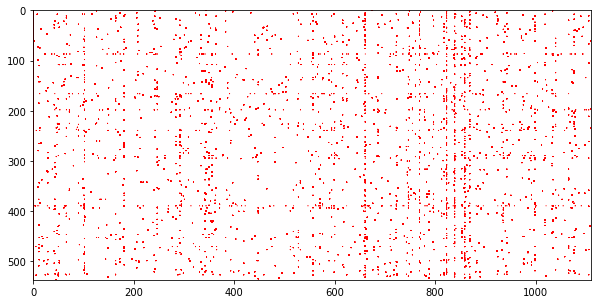

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(X[::20, ::20].todense(), cmap=cmap, vmin=-vmax, vmax=vmax)

In [ ]:
def reduce_X(X, row_factor=50, col_factor=50):
    nrows, ncols = np.shape(X)
#    nrows_red = nrows//row_factor
#    ncols_red = ncols//col_factor
    nrows_red = int(np.ceil(nrows/row_factor))
    ncols_red = int(np.ceil(ncols/col_factor))
    reducida = np.zeros((nrows_red, ncols_red))
    aux_row = 0
    for row in range(nrows_red):
        print("{} / {}".format(row+1, nrows_red))
        aux_col = 0
        for col in range(ncols_red):
            reducida[row,col] = X[aux_row:(aux_row+row_factor),
                                  aux_col:(aux_col+col_factor)].mean()
            aux_col += col_factor
        aux_row += row_factor
#    reducida /= (row_factor*col_factor)
    return reducida

In [ ]:
row_factor = 50
col_factor = 50
reducida_X = reduce_X(X, row_factor=row_factor)
reducida_fit_data = reduce_X(fit_data, row_factor=row_factor)

1 / 215
2 / 215
3 / 215
4 / 215
5 / 215
6 / 215
7 / 215
8 / 215
9 / 215
10 / 215
11 / 215
12 / 215
13 / 215
14 / 215
15 / 215
16 / 215
17 / 215
18 / 215
19 / 215
20 / 215
21 / 215
22 / 215
23 / 215
24 / 215
25 / 215
26 / 215
27 / 215
28 / 215
29 / 215
30 / 215
31 / 215
32 / 215
33 / 215
34 / 215
35 / 215
36 / 215
37 / 215
38 / 215
39 / 215
40 / 215
41 / 215
42 / 215
43 / 215
44 / 215
45 / 215
46 / 215
47 / 215
48 / 215
49 / 215
50 / 215
51 / 215
52 / 215
53 / 215
54 / 215
55 / 215
56 / 215
57 / 215
58 / 215
59 / 215
60 / 215
61 / 215
62 / 215
63 / 215
64 / 215
65 / 215
66 / 215
67 / 215
68 / 215
69 / 215
70 / 215
71 / 215
72 / 215
73 / 215
74 / 215
75 / 215
76 / 215
77 / 215
78 / 215
79 / 215
80 / 215
81 / 215
82 / 215
83 / 215
84 / 215
85 / 215
86 / 215
87 / 215
88 / 215
89 / 215
90 / 215
91 / 215
92 / 215
93 / 215
94 / 215
95 / 215
96 / 215
97 / 215
98 / 215
99 / 215
100 / 215
101 / 215
102 / 215
103 / 215
104 / 215
105 / 215
106 / 215
107 / 215
108 / 215
109 / 215
110 / 215
111 / 21

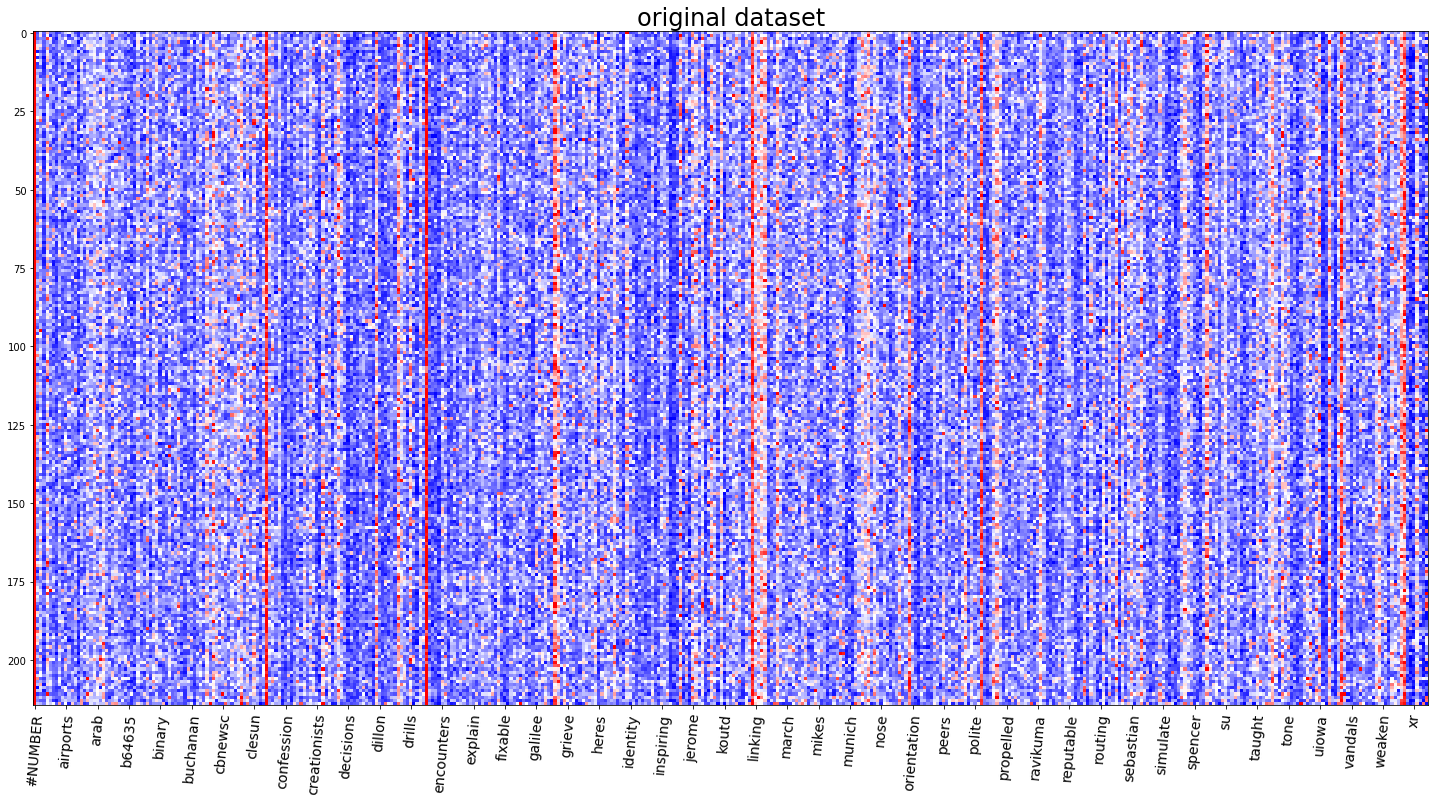

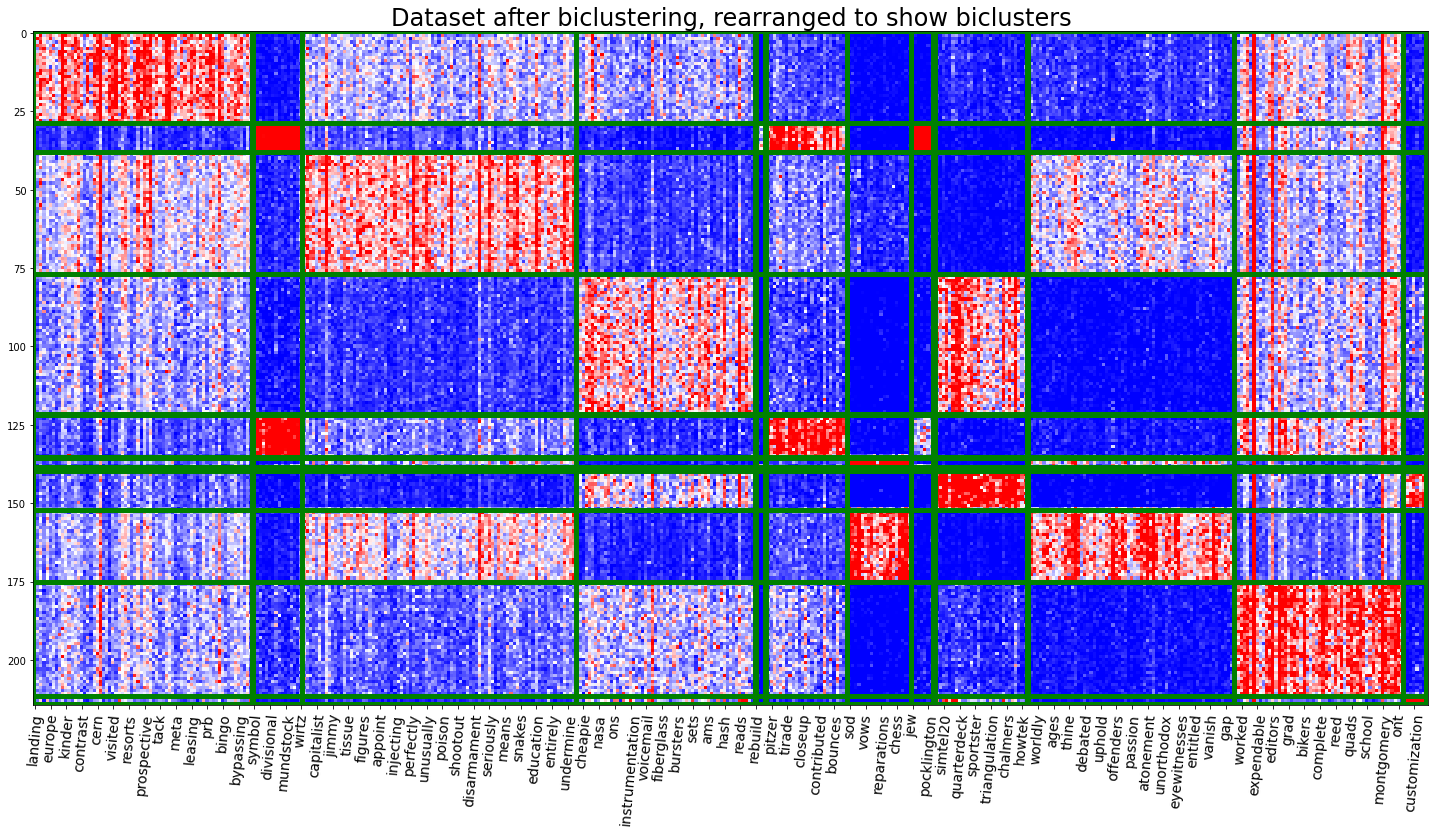

In [ ]:
n_clusters = cocluster.n_clusters

plt.figure(figsize=(25,25))
#plt.subplot(1,2,1)
plt.imshow(reducida_X, cmap=cmap, vmin=0, vmax=vmax)
plt.xticks(range(len(np.array(feature_names)[::col_factor]))[::10],
           np.array(feature_names)[::col_factor][::10],
           fontsize=14, rotation=85)
plt.title("original dataset", fontsize=24)
plt.show()

plt.figure(figsize=(25,25))
#plt.subplot(1,2,2)
plt.imshow(reducida_fit_data, cmap=cmap, vmin=0, vmax=vmax)
plt.xticks(range(len(np.array(feature_names)[::col_factor]))[::5],
           np.array(feature_names)[sorted_cols_inds][::col_factor][::5],
           fontsize=14, rotation=85)
plt.title("Dataset after biclustering, rearranged to show biclusters", fontsize=24)
corner_y = -0.5
c = 0
for i in range(n_clusters):
    corner_x = -0.5
    for j in range(n_clusters):
#        sh = cocluster.get_shape(i)
        sh = [cocluster.get_shape(i)[0]/row_factor,
              cocluster.get_shape(j)[1]/col_factor]
        plt.plot([corner_x, corner_x+sh[1], corner_x+sh[1], corner_x, corner_x],
                 [corner_y, corner_y, corner_y+sh[0], corner_y+sh[0], corner_y], 'g', linewidth=5)
        corner_x += sh[1]
        c += 1
    corner_y += sh[0]

Va a intentar que palabras parecidas las ponga cerca. En biclustering te reordena a la vez filas y columnas.